# Feature Evolution with Phase

This notebook explores the evolution of feature properties (e.g., pEW and velocities) as a function of phase.


In [3]:
from pathlib import Path

import matplotlib.pyplot as plt
import yaml

from utils import read_in_pipeline_result


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: TableReplaceWarning: converted column 'ndofSALT2zspec' from integer to float
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: TableReplaceWarning: converted column 'ndofMLCS2k2zspec' from integer to float
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: TableReplaceWarning: converted column 'lcqualityIaPSNIDzspec' from integer to float
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: TableReplaceWarning: converted column 'lcqualityIbcPSNIDzspec' from integer to float
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: TableReplaceWarning: converted column 'lcqualityIIPSNIDzspec' from integer to float
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: TableReplaceWarning: converted column 'NnnPSNIDzspec' from integer to float
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: TableReplaceWarning: 

## Read in Data

We read in final measurements taken collaboratively by all group members

In [4]:
results_dir = Path('.').resolve() .parent / 'results'
csp_final = read_in_pipeline_result(results_dir / 'final_csp.csv', 'csp', drop_flagged=True)
sdss_final = read_in_pipeline_result(results_dir / 'final_sdss.csv', 'sdss', drop_flagged=True)


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: TableReplaceWarning: converted column 'ndofSALT2zspec' from integer to float
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: TableReplaceWarning: converted column 'ndofMLCS2k2zspec' from integer to float
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: TableReplaceWarning: converted column 'lcqualityIaPSNIDzspec' from integer to float
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: TableReplaceWarning: converted column 'lcqualityIbcPSNIDzspec' from integer to float
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: TableRe

## Classification Results

In [12]:
def plot_branch_classifications(pipeline_data, phase_cutoff=7, figsize=(10, 10)):
    """Create a Branch classification figure
    
    Args:
        pipeline_data (DataFrame): Data that has been read from a pipeline output file
        phase_cutoff      (float): Only use measurements taken within so many days of peak brightness
        fig_size          (Tuple): Size of the figure in inches
    """
    
    fig, axis = plt.subplots(figsize=figsize)
    
    plot_args = {
        #'CL': dict(label='Cool', color='blue', marker='s'),
        #'BL': dict(label='Broad Line', color='red' , marker='^'),
        #'SS': dict(label='Shallow Silicon', color='green' , marker= '*'),
        #'CN': dict(label='Core Normal', color='black' , marker= '.')
        'CL': dict(label='Cool', color='blue', marker='.'),
        'BL': dict(label='Broad Line', color='red', marker='.'),
        'SS': dict(label='Shallow Silicon', color='green', marker='.'),
        'CN': dict(label='Core Normal', color='black', marker='.')
    }
    peak_vals = pipeline_data[pipeline_data.is_peak]
    peak_vals = peak_vals[peak_vals.delta_t <= phase_cutoff]
    
    pw6_data = peak_vals[['pew', 'pew_samperr', 'branch_type']].loc['pW6']
    all_data = pw6_data.join(peak_vals[['pew', 'pew_samperr']].loc['pW7'], lsuffix='_6', rsuffix='_7').dropna()
    for branch_class, data in all_data.groupby('branch_type'):
        label = plot_args[branch_class].pop('label') + f' ({len(data)})'
        axis.errorbar(
            data.pew_7, 
            data.pew_6, 
            xerr=data.pew_samperr_7,
            yerr=data.pew_samperr_6,
            linestyle='',
            label=label,
            **plot_args.get(branch_class, dict()))
    
    plt.title('Strength of pW6 vs pW7')
    axis.legend(loc = ('upper left'))
    plt.xlabel('pew of pW7')
    plt.ylabel('pew of pW6')
    

No handles with labels found to put in legend.


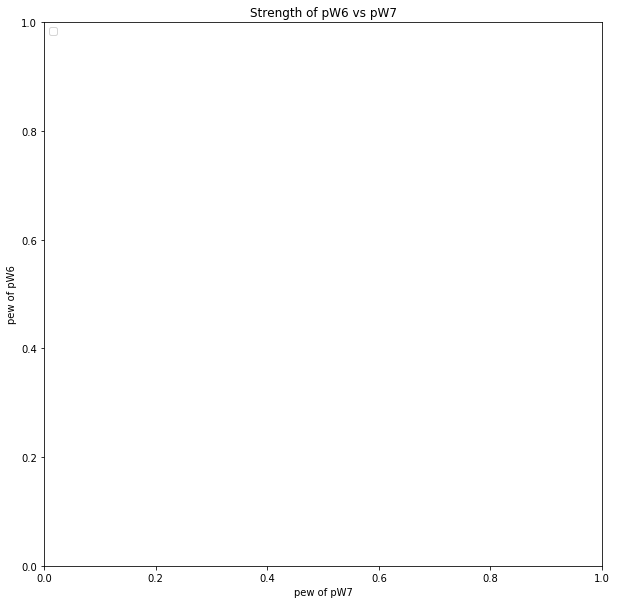

In [13]:
plot_branch_classifications(csp_final)


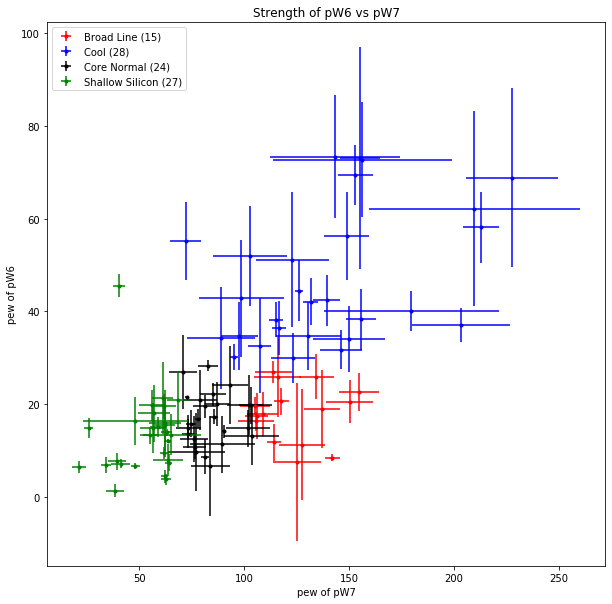

In [9]:
plot_branch_classifications(sdss_final)


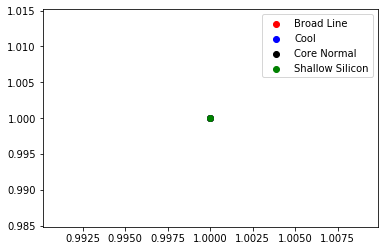

In [14]:
x = [1]
y = [1]
plt.scatter(x, y, color='red', label='Broad Line')
plt.scatter(x, y, color='blue', label='Cool')
plt.scatter(x, y, color='black', label='Core Normal')
plt.scatter(x, y, color='green', label='Shallow Silicon')
plt.legend()